In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time
from training.util import plot_losses

In [115]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.TwoMoonsDataset(samples=200, noise=0.15, seed=13)
trainloader = torch.utils.data.DataLoader(trainset.dataset(), batch_size, shuffle=True)

testset = toy.TwoMoonsDataset(samples=200, noise=0.15, seed=0)

device = torch.device("cpu")

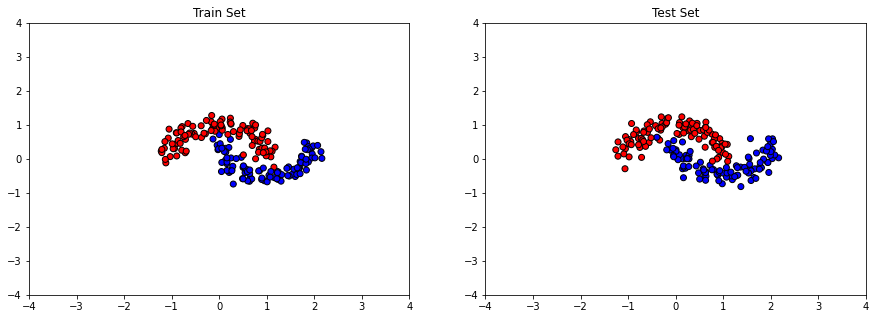

In [134]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

eval_points = 100
sample_cmap = ListedColormap(["red", "blue"])
area_cmap = plt.cm.RdBu
variance_cmap = plt.cm.viridis
xlim = 4
ylim = 4

def plot_samples(ax, dataset):
    ax.scatter(dataset.samples[:,0], dataset.samples[:,1], c=dataset.labels, cmap=sample_cmap, edgecolors="black")

def plot(name, eval, samples, show_data=True, include_caption=True):
    with torch.no_grad():
        fig, value_ax = plt.subplots(1, 1)
        if include_caption:
            fig.suptitle(name)
        value_ax.set_xlim(-xlim, xlim)
        value_ax.set_ylim(-ylim, ylim)
        value_ax.set_axis_off()
        
        # Grid evaluation
        xs, ys = np.meshgrid(np.linspace(-xlim, xlim, eval_points), np.linspace(-ylim, ylim, eval_points))
        data = np.dstack((xs.reshape(eval_points * eval_points), ys.reshape(eval_points * eval_points)))[0]
        with torch.no_grad():
            results = eval(torch.from_numpy(data).float(), samples).reshape((samples, eval_points, eval_points))
        value_ax.contourf(xs, ys, results.mean(dim=0), 100, cmap=area_cmap)

        # Training samples
        with torch.no_grad():
            results = eval(testset.samples, samples)
        predictions = torch.round(results.mean(dim=0))
        corrects = (predictions == testset.labels).sum()
        print(f"Test accuracy {corrects} / {len(predictions)} ({(corrects / len(predictions)):.3f})")
        if show_data:
            value_ax.scatter(*zip(*testset.samples), facecolors=sample_cmap(predictions), edgecolors=sample_cmap(testset.labels))

        fig.tight_layout(pad=0)
        return fig

fig, (train_fig, test_fig) = plt.subplots(1, 2, figsize=(15, 5))
train_fig.set_title("Train Set")
train_fig.set_xlim(-xlim, xlim)
train_fig.set_ylim(-ylim, ylim)
test_fig.set_title("Test Set")
test_fig.set_xlim(-xlim, xlim)
test_fig.set_ylim(-ylim, ylim)
plot_samples(train_fig, trainset)
plot_samples(test_fig, testset)

In [120]:
layers = [
    ("fc", (2, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
def sgd(lr):
    return lambda parameters: torch.optim.SGD(parameters, lr)

Final loss 0.026620278134942055
Test accuracy 198 / 200 (0.990)


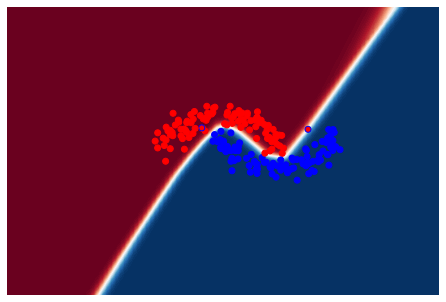

In [148]:
from training.pp import PointPredictor
torch.manual_seed(42)

pp = PointPredictor(layers)
pp.train_model(50, nn.BCELoss(), sgd(lr=0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("MAP", pp.infer, 1, include_caption=False).savefig("results/toy/classification/map.pdf")

Final loss 0.02543114498257637
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Test accuracy 199 / 200 (0.995)


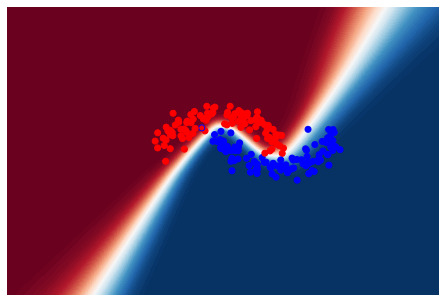

In [142]:
from training.swag import SwagModel
torch.manual_seed(42)

swag_config = {
    "start_epoch": 40,
    "update_every_batches": len(trainloader),
    "deviation_samples": 30
}
swag = SwagModel(layers, swag_config)
swag.train_model(70, nn.BCELoss(), sgd(lr=0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("SWAG", swag.infer, 1000, include_caption=False).savefig("results/toy/classification/swag.pdf")

Training ensemble member 0
Final loss 0.03140968829393387
Training ensemble member 1
Final loss 0.026941070333123207
Training ensemble member 2
Final loss 0.02536292001605034
Training ensemble member 3
Final loss 0.021316688507795334
Training ensemble member 4
Final loss 0.02255288138985634
Test accuracy 197 / 200 (0.985)


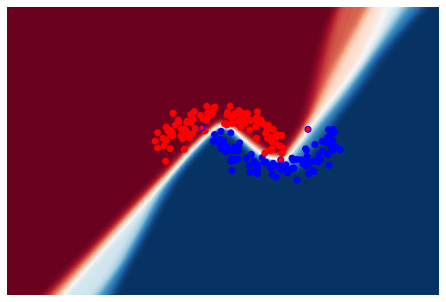

In [139]:
from training.ensemble import Ensemble
torch.manual_seed(42)

ensemble = Ensemble([PointPredictor(layers) for _ in range(5)])
ensemble.train_model(50, nn.BCELoss(), sgd(0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("Ensemble-5", ensemble.infer, 5, include_caption=False).savefig("results/toy/classification/ensemble.pdf")

Final loss 0.0879640206694603
Test accuracy 197 / 200 (0.985)


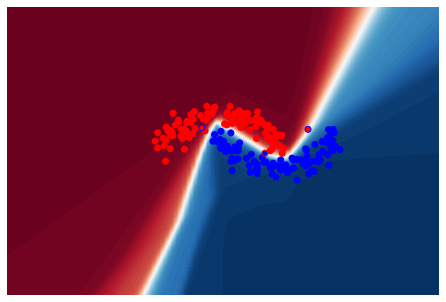

In [140]:
from training.dropout import MonteCarloDropoutModule
torch.manual_seed(42)

mc_dropout = MonteCarloDropoutModule(layers, 0.1)
mc_dropout.train_model(70, nn.BCELoss(), sgd(0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("MC Dropout", mc_dropout.infer, 1000, include_caption=False).savefig("results/toy/classification/mc_dropout.pdf")

Epoch 0: loss 0.7737604379653931
Epoch 10: loss 0.5710124969482422
Epoch 20: loss 0.5316157937049866
Epoch 30: loss 0.46112704277038574
Epoch 40: loss 0.44527485966682434
Epoch 50: loss 0.436838299036026
Epoch 60: loss 0.4241820275783539
Epoch 70: loss 0.4156533181667328
Epoch 80: loss 0.40881645679473877
Epoch 90: loss 0.3964215815067291
Epoch 100: loss 0.3908061981201172
Epoch 110: loss 0.3844131529331207
Epoch 120: loss 0.3738057315349579
Epoch 130: loss 0.3671528697013855
Epoch 140: loss 0.35573703050613403
Epoch 150: loss 0.3568463623523712
Epoch 160: loss 0.3475663363933563
Epoch 170: loss 0.3408060371875763
Epoch 180: loss 0.33554619550704956
Epoch 190: loss 0.31835347414016724
Epoch 200: loss 0.3183606266975403
Epoch 210: loss 0.3114302456378937
Epoch 220: loss 0.30453309416770935
Epoch 230: loss 0.3040883541107178
Epoch 240: loss 0.29734665155410767
Epoch 250: loss 0.28947117924690247
Epoch 260: loss 0.2783794701099396
Epoch 270: loss 0.27476510405540466
Epoch 280: loss 0.2706

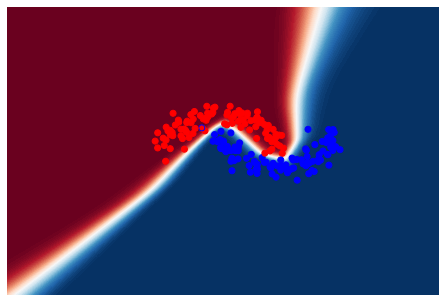

In [154]:
from training.bbb import BBBModel, GaussianPrior
torch.manual_seed(42)

bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", layers, init="blundell")
bbb.train_model(300, nn.BCELoss(), sgd(lr=0.05), trainloader, batch_size, device, kl_rescaling=0.2, report_every_epochs=10)

plot("Bayes By Backprop", bbb.infer, 1000, include_caption=False).savefig("results/toy/classification/bbb_0_2.pdf")

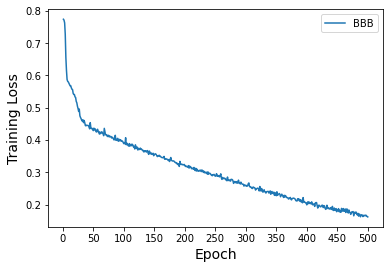

In [153]:
plot_losses("BBB", bbb.all_losses(), plt.subplot())